<a href="https://colab.research.google.com/github/TomoharuKurosu/Tomoharu_DS2/blob/main/boruta_suc_house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install rdkit
!pip install dcekit
!pip install boruta

In [12]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.figure as figure
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from dcekit.variable_selection import search_high_rate_of_same_values, search_highly_correlated_variables
from boruta import BorutaPy

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
#データの読み込み
df = pd.read_csv("/content/drive/MyDrive/Bostonhousedata2.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# データの確認
print(df.head())  # データの確認用。目的変数が '住宅価格' であることを確認

   house_price    crime  big_house  near_river     co  average_room  old_rate  \
0         24.0  0.00632       18.0           0  0.538         6.575      65.2   
1         21.6  0.02731        0.0           0  0.469         6.421      78.9   
2         34.7  0.02729        0.0           0  0.469         7.185      61.1   
3         33.4  0.03237        0.0           0  0.458         6.998      45.8   
4         36.2  0.06905        0.0           0  0.458         7.147      54.2   

   access_highway  tax  student_teacher  low_salary  
0               1  296             15.3        4.98  
1               2  242             17.8        9.14  
2               2  242             17.8        4.03  
3               3  222             18.7        2.94  
4               3  222             18.7        5.33  


In [40]:
# 説明変数と目的変数を設定
X = df.drop('house_price', axis=1).values  # '住宅価格'列以外が説明変数　axis=1で列指定　axis=0で行指定
y = df['house_price'].values  # '住宅価格'が目的変数　valuesで数値化

#StandardScalerを使って標準化
scaler_X = StandardScaler()
#scaler_y = StandardScaler()
scaled_X = scaler_X.fit_transform(X)
#scaled_y = scaler_y.fit_transform(y)


# ランダムフォレストモデルの定義
rf = RandomForestRegressor(n_estimators=100, random_state=42)
#要協議が必要

# Borutaによる特徴選択 ver1
boruta_selector = BorutaPy(rf, n_estimators='auto', random_state=42, alpha=0.05)
boruta_selector.fit(scaled_X, y)

# 選ばれた特徴量をDataFrameに変換
scaled_selected_features = df.drop('house_price', axis=1).columns[boruta_selector.support_].tolist()

# 結果の表示
print("住宅価格に関係する重要な変数:", scaled_selected_features)

##selected_featuresは自分で出した（簡易的なものなのかもしれない）

住宅価格に関係する重要な変数: ['crime', 'co', 'average_room', 'old_rate', 'tax', 'student_teacher', 'low_salary']


In [44]:

# 選択されるまえの特徴量でデータを分割
#scaled_X_selected = df[scaled_selected_features].values
scaled_X_train, scaled_X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

#Borutaによる変数選択 version2
#pパーセンタイルの最適化
corr_list = []
for n in range(10000):
    shadow_features = np.random.rand(scaled_X_train.shape[0]).T
    corr = np.corrcoef(scaled_X_train, shadow_features,rowvar=False)[-1]
    corr = abs(corr[corr < 0.95])
    corr_list.append(corr.max())

corr_array = np.array(corr_list)
perc = 100 * (1-corr_array.max())

#Borutaの実施
feat_selector = BorutaPy(rf,
n_estimators='auto',  # 特徴量の数に比例して、木の本数を増やす
verbose=0,
alpha=0.05, # 有意水準
max_iter=100, # 試行回数
perc = perc, #ランダム生成変数の重要度の何％を基準とするか
random_state=0
)
feat_selector.fit(scaled_X_train, y_train)
scaled_X_train_br = scaled_X_train[:,feat_selector.support_]
scaled_X_test_br = scaled_X_test[:,feat_selector.support_]

# 選ばれた特徴量をDataFrameに変換
scaled_selected_features_2 = df.drop('house_price', axis=1).columns[feat_selector.support_].tolist()

# 結果の表示
print('pパーセンタイル:',round(perc,2))
print('boruta後の変数の数:',scaled_X_train_br.shape[1])
print("住宅価格に関係する重要な変数:", scaled_selected_features_2)

住宅価格に関係する重要な変数: ['crime', 'co', 'average_room', 'old_rate', 'tax', 'student_teacher', 'low_salary']
pパーセンタイル: 78.5
boruta後の変数の数: 7


In [45]:
# 選択された特徴量でデータを分割 ver1
scaled_X_selected = df[scaled_selected_features].values
scaled_X_train_boruta, scaled_X_test_boruta, y_train, y_test = train_test_split(scaled_X_selected, y, test_size=0.2, random_state=42)

# boruta使用した場合の特徴量でデータを分割
# モデルの学習
rf.fit(scaled_X_train_boruta, y_train)

# 予測
y_pred_test_boruta = rf.predict(scaled_X_test_boruta)

# モデルの評価
print("borurta使用後R²スコア:", r2_score(y_test, y_pred_test_boruta))
print("borurta使用後平均絶対誤差:", mean_absolute_error(y_test, y_pred_test_boruta))
print("borurta使用後平均二乗誤差:", mean_squared_error(y_test, y_pred_test_boruta))

borurta使用後R²スコア: 0.8631999676413594
borurta使用後平均絶対誤差: 2.0948774509803902
borurta使用後平均二乗誤差: 10.032063909313713


In [27]:
# boruta使用しない場合の特徴量でデータを分割
#X_selected = df[selected_features].values
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=0.2, random_state=42)

# モデルの学習
rf.fit(X_train_ori, y_train_ori)

# 予測
y_pred_ori = rf.predict(X_test_ori)

# モデルの評価
print("borurta使用前R²スコア:", r2_score(y_test, y_pred_ori))
print("borurta使用前平均絶対誤差:", mean_absolute_error(y_test, y_pred_ori))
print("borurta使用前平均二乗誤差:", mean_squared_error(y_test, y_pred_ori))

borurta使用前R²スコア: 0.8175953540947073
borurta使用前平均絶対誤差: 2.163540010598834
borurta使用前平均二乗誤差: 13.376422750254228


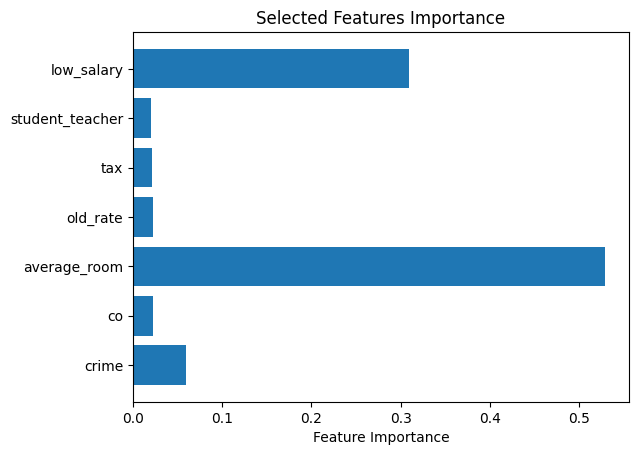

In [26]:
import matplotlib.pyplot as plt

# 特徴量の重要度を取得
importances = rf.feature_importances_[boruta_selector.support_]

# 可視化
plt.barh(selected_features, importances)
plt.xlabel('Feature Importance')
plt.title('Selected Features Importance')
plt.show()
